# Recommendation System

## Business Understanding

The analysis below is for a custom recommendation system for songs.  The data chosen for training/testing came from the [Million Song Dataset Challenge](https://www.kaggle.com/c/msdchallenge#description). The dataset was originally provided by The Echo Nest and made available by [Columbia University](https://labrosa.ee.columbia.edu/millionsong/) with the puprose encouraging research in machine learning. 


###   this is probably my misunderstanding.   are we predicting next song?   or are we predicting the songs a user will like.   
With this dataset, we will attempt to predict which song a user will want to listen to next.

## Data Understanding

The analysis will involve two datasets.   The song usage data and the song information data.

The first is the Taste Profile subset.   The data includes a unique hash value for each user along with the song identification number and the number of times the user has played that particular song.  The data was not gathered over a specified time.  Rather the data is dependent upon the user having a minimum of 10 unique songs.  

The second dataset is the song data which provides details about the song.  The usage data only contains the song identification number while the song data provides the song title, artist, release, and year.  

Downloading the usage and song data:

In [7]:
%%capture

import graphlab as gl
import graphlab.aggregate as agg
from matplotlib import pyplot as plt
usage_data = gl.SFrame.read_csv("../data/kaggle_visible_evaluation_triplets.txt",
                                header=False,
                                delimiter='\t',
                                column_type_hints={'X3':int})

songs = gl.SFrame.read_csv("../data/song_data.csv")

Change data labels to be human readable:

In [8]:
%%capture
print(usage_data.rename({'X1':'user', 'X2': 'song_id', 'X3': 'plays'}))

The usage data has three fields (`user`, `song_id`, and `plays`) which describes how many times (`play`) a `song` is listened to by a `user`.

In [9]:
Tusage_data.head()

user,song_id,plays
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOBONKR12A58A7A7E0,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOEGIYH12A6D4FC0E3,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOFLJQZ12A6D4FADA6,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOHTKMO12AB01843B0,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SODQZCY12A6D4F9D11,1
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOXLOQG12AF72A2D55,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUVUHC12A67020E3B,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUQERE12A58A75633,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOIPJAX12A8C141A2D,1
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOEFCDJ12AB0185FA0,2


The song data has five fields (`song_id`, `title`, `release`, `artist_name`, and `year`.

In [10]:
songs.head()

song_id,title,release,artist_name,year
SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze PresentsWinter Sessions ...,Der Mystic,0
SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor""Sinfonie ...",Berwald: Symphonies Nos.1/2/3/4 ...,David Montgomery,0
SOQVRHI12A6D4FB2D7,We Have Got Love,Strictly The Best Vol. 34,Sasha / Turbulence,0
SOEYRFT12AB018936C,2 Da Beat Ch'yall,Da Bomb,Kris Kross,1993
SOPMIYT12A6D4F851E,Goodbye,Danny Boy,Joseph Locke,0
SOJCFMH12A8C13B0C2,Mama_ mama can't you see? ...,March to cadence with theUS marines ...,The Sun Harbor's Chorus-Documentary Recordings ...,0


To enhance the `usage_data` records details from `songs` data will be included.   The inclusion of the details will allow for subjective review as well as expand the analysis from song usage to artist usage.  A merge on the `usage_data` and `songs` datasets will provide the needed details.

In [11]:
ud_df = usage_data.to_dataframe()
song_df = songs.to_dataframe()

new_df = ud_df.merge(song_df, how='left', left_on='song_id', right_on='song_id')

combo_songs = gl.SFrame(new_df)
combo_songs['user', 'title', 'artist_name', 'plays'].head

<bound method SFrame.head of Columns:
	user	str
	title	str
	artist_name	str
	plays	int

Rows: 1491952

Data:
+-------------------------------+-------------------------------+
|              user             |             title             |
+-------------------------------+-------------------------------+
| fd50c4007b68a3737fe052d5a4... |         You're The One        |
| fd50c4007b68a3737fe052d5a4... | Horn Concerto No. 4 in E f... |
| fd50c4007b68a3737fe052d5a4... |            Tive Sim           |
| fd50c4007b68a3737fe052d5a4... | Catch You Baby (Steve Pitr... |
| fd50c4007b68a3737fe052d5a4... |          El Cuatrero          |
| fd50c4007b68a3737fe052d5a4... | Unite (2009 Digital Remaster) |
| d7083f5e1d50c264277d624340... |           Lift Me Up          |
| d7083f5e1d50c264277d624340... |        Living In A Lie        |
| d7083f5e1d50c264277d624340... |         Open Your Eyes        |
| d7083f5e1d50c264277d624340... |           Kurtizana           |
+-------------------------------+

Collaborative filtering based on song and user is the primary objective.  In addition, the user and artist data will be analyzed in the same fashion to determine the preferred method.   Both models will be trained, tested, and compared.  

In [12]:
df_artist = new_df.groupby(by=['user','artist_name'])[['plays']].sum().reset_index()
df_artist.head()

artist = gl.SFrame(df_artist)
artist.head

<bound method SFrame.head of Columns:
	user	str
	artist_name	str
	plays	int

Rows: 1133382

Data:
+-------------------------------+--------------------------------+-------+
|              user             |          artist_name           | plays |
+-------------------------------+--------------------------------+-------+
| 00007a02388c208ea7176479f6... |             Dredg              |   3   |
| 00007a02388c208ea7176479f6... |            Local H             |   1   |
| 00007a02388c208ea7176479f6... |              M83               |   2   |
| 00007a02388c208ea7176479f6... |            No Doubt            |   1   |
| 00007a02388c208ea7176479f6... |            Pantera             |   1   |
| 00007a02388c208ea7176479f6... |           Sam Sparro           |   2   |
| 00007a02388c208ea7176479f6... |      Stone Temple Pilots       |   3   |
| 00014a76ed063e1a749171a253... |      Angels and Airwaves       |   4   |
| 00014a76ed063e1a749171a253... |           Moodymann            |   2   |
| 

### Data Visualization

The dataset being utilized for the project is significant in size.   Due to the size, the visuals can be challenging to present.  To provide an image of the number of songs and the number of plays, each entry was categorized based on the number of plays.  The pie chart below shows the percentage of songs in each category.   

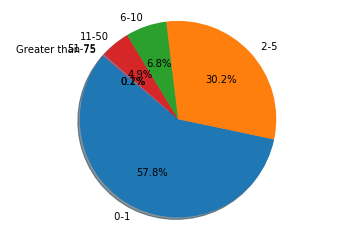

In [23]:
#Create the category function
def f(row):
    if row['plays'] <= 1:
        val = ' 0-1'
    elif row['plays'] <= 5:
        val = ' 2-5'
    elif row['plays'] <= 10:
        val =  ' 6-10'
    elif row['plays'] <= 50:
        val =  '11-50'
    elif row['plays'] <= 75:
        val =  '51-75'
    elif row['plays'] >75:
        val =  'Greater than 75'
    return val

#Apply the category function 
new_df['category'] = new_df.apply(f, axis=1)

#Confirm the new category added
new_df.head()

#Group by categories

pie_chart = new_df.groupby(by=['category'])[['plays']].count().reset_index()

pie_chart.head()

#Plot
plt.pie(pie_chart['plays'], labels=pie_chart['category'], autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

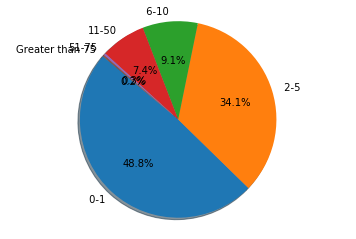

In [24]:
#Apply the category function 
df_artist['category'] = df_artist.apply(f, axis=1)
                                  
art_pc = df_artist.groupby(by=['category'])[['plays']].count().reset_index()
art_pc.head()

plt.pie(art_pc['plays'], labels=art_pc['category'], autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

With the song data, over half of the information is based on a song being played a single time.  All data will remain in the analysis; however, the model will be chosen to consider the number of times the song was played.

In [25]:
combo_songs.show()

Canvas is accessible via web browser at the URL: http://localhost:4454/index.html
Opening Canvas in default web browser.


In [22]:
artist.show()

Canvas is updated and available in a tab in the default browser.


Executing the `graphlab show` will provide summary information about the data in a local browser using GraphLab Canvas.   

The song data includes over 110,000 users listening to over 166,433 unique songs.   The data includes 138,499 unqiue song titles.   The inference is 27,934 songs have the same title although they are different songs.   Analysis will need to be done on the `song_id` rather than the `title`.   Songs were played between 1 times and 923 times.  Both the song data as well as the artist data contain 28,266 unique artists.   Neither dataset has missing values.  The year has some missing values that are populated with 0.  Detail on the missing years can be found in the GraphLab Canvas.   Due to 20% of the year data missing, analysis will not include the year informaiton.  

Since the user identification is based on a user ID, the possiblities of a single person having multiple user IDs or a single user ID being used by multiple individuals cannot be eliminated.   Since the sharing of user IDs is common with families, our analysis will proceed with caution.  

## Train and Adjust parameters

In [6]:
combo_songs

user,song_id,plays,title,release
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOBONKR12A58A7A7E0,1,You're The One,If There Was A Way
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOEGIYH12A6D4FC0E3,1,Horn Concerto No. 4 in Eflat K495: II. Romance ...,Mozart - Eine kleineNachtmusik ...
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOFLJQZ12A6D4FADA6,1,Tive Sim,Nova Bis-Cartola
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOHTKMO12AB01843B0,1,Catch You Baby (StevePitron & Max Sanna Radio ...,Catch You Baby
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SODQZCY12A6D4F9D11,1,El Cuatrero,From Argentina To TheWorld ...
fd50c4007b68a3737fe052d5a4f78ce8aa117f3d ...,SOXLOQG12AF72A2D55,1,Unite (2009 DigitalRemaster) ...,Hello Nasty (RemasteredEdition) ...
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUVUHC12A67020E3B,1,Lift Me Up,Lift Me Up EP
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOUQERE12A58A75633,1,Living In A Lie,Planet Of The Apes - BestOf Guano Apes ...
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOIPJAX12A8C141A2D,1,Open Your Eyes,Nice 90s
d7083f5e1d50c264277d624340edaaf3dc16095b ...,SOEFCDJ12AB0185FA0,2,Kurtizana,Bud a nebe


#### Song Recommendation
The following is the training and testing of the song usage data.  The analysis includes both the user and the song information.    

A recommender based on the plays from users will be created.  The recommender will suggest 5 songs for each user based on the feedback from other users.

In [30]:
train_song, test_song = gl.recommender.util.random_split_by_user(combo_songs,
                                                      user_id="user", item_id="song_id",
                                                      item_test_proportion=0.2)

from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

song_rec = gl.recommender.item_similarity_recommender.create(train_song,
                                                             user_id="user",
                                                             item_id="song_id",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="cosine")

rmse_results = song_rec.evaluate(test_song)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Warning: Ignoring columns title, release, artist_name, year;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 1489352 observations with 110000 users and 163095 items.

Data prepared in: 2.28708s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.001ms                        | 0.75       |

| 123.098ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing the 32 most common items by brute force search.

Transposing user-item lists for use in nearest neighbor search.

+------------------------------------+------------+

| Elapsed Time (Data Transposition)) | % Complete |

+------------------------------------+------------+

| 18.014ms                           | 0          |

| 355.811ms                          | 100        |

+------------------------------------+------------+

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 548.166ms                           | 0                | 0               |

+-------------------------------------+------------------+-----------------+

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.84s                               | 0                | 32              |

| 4.85s                               | 57.25            | 93453           |

| 6.95s                               | 100              | 163095          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 7.16244s


Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.00463499420626 | 0.00225955967555 |
|   2    | 0.00405561993048 | 0.00375627655465 |
|   3    | 0.00463499420626 | 0.00604618440656 |
|   4    | 0.00434530706837 | 0.00690145119461 |
|   5    | 0.00370799536501 | 0.0072877007118  |
|   6    | 0.0032831208961  | 0.00757738784969 |
|   7    | 0.00413838768416 | 0.0110260442532  |
|   8    | 0.00405561993048 |  0.011875793191  |
|   9    | 0.00411999485001 | 0.0149382000772  |
|   10   | 0.00417149478563 | 0.0155285393119  |
+--------+------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 6.278737324614114)

Per User RMSE (best)
+-------------------------------+-------+----------------+
|              user             | count |      rmse      |
+-------------------------------+-------+----------------+
|

In [31]:
rmse_results['rmse_overall']

song_id,count,rmse
SOZEJTU12A8C1422B8,1,1.0
SOEKEWC12A8C132A59,1,1.0
SOQIPYO12AAF3B5B1D,1,10.0
SOYIOZB12A58A797FC,1,4.0
SOPCFDZ12A58A7A13C,1,1.0
SOANOGG12A6D4FA13F,1,2.0
SOLACVK12A8C13ABAA,1,1.0
SOOCALE12A6701EB05,1,1.0
SOZVCRW12A67ADA0B7,3,5.35412613474
SOSZAST12A6D4F6245,1,2.0


In [32]:
rmse_results['rmse_by_user']

user,count,rmse
afa789497ac76be6b065f0798f1b32dc88b74e07 ...,3,1.0
bef3adf0c1b916ac9b549f77984fb607701359c0 ...,3,5.0
9156df28bd49301f03306f6016faba0ab4a240cb ...,2,1.0
d9a7bbc39cb6cae61b959de6da778a9ab30c2f14 ...,3,1.0
c174d59c27220c94999bf67cd98fd3eca67f7ab0 ...,4,1.0
1be569aefb976bae9aa6a29af47db2e8d666dcd2 ...,9,4.20317340431
ee2e4d4bceccab6ed27930d2b643f4aa5d51b5a2 ...,1,1.45343492031
ad735bb68f23dd440dc86a66706bef6a9e61d7c8 ...,1,1.0
e7a396b784c0140d0d86930b49ab309c8d93e93b ...,2,10.4920118747
bec7714c456d4fc41bd194ba49c8dc6f9c1bc02e ...,4,6.61437827766


In [33]:
rmse_results['rmse_by_item']

song_id,count,rmse
SOZEJTU12A8C1422B8,1,1.0
SOEKEWC12A8C132A59,1,1.0
SOQIPYO12AAF3B5B1D,1,10.0
SOYIOZB12A58A797FC,1,4.0
SOPCFDZ12A58A7A13C,1,1.0
SOANOGG12A6D4FA13F,1,2.0
SOLACVK12A8C13ABAA,1,1.0
SOOCALE12A6701EB05,1,1.0
SOZVCRW12A67ADA0B7,3,5.35412613474
SOSZAST12A6D4F6245,1,2.0


#### Artist Recommendation
Music recommendations may be offered in multiple forms.  In addition to the recommendation of songs, the analysis includes the recommendation of music by artist.  The data was trained as tested the same as the song data to offere comparison of the two collaborative filtering results.   

In [35]:
train_art, test_art = gl.recommender.util.random_split_by_user(artist,
                                                      user_id="user", item_id="artist_name",
                                                      item_test_proportion=0.2)

from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

art_rec = gl.recommender.item_similarity_recommender.create(train_art,
                                                             user_id="user",
                                                             item_id="artist_name",
                                                             target="plays",
                                                             only_top_k=5,
                                                             similarity_type="cosine")

rmse_results = art_rec.evaluate(test_art)

print rmse_results.viewkeys()

Recsys training: model = item_similarity

Preparing data set.

Data has 1131349 observations with 109996 users and 28359 items.

Data prepared in: 1.7771s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 0us                            | 3.5        |

| 83.802ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.18s                               | 0                | 0               |

| 5.18s                               | 70.25            | 19971           |

| 14.30s                              | 100              | 28359           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 14.6044s


Precision and recall summary statistics by cutoff
+--------+------------------+------------------+
| cutoff |  mean_precision  |   mean_recall    |
+--------+------------------+------------------+
|   1    | 0.0024154589372  | 0.00144927536232 |
|   2    | 0.0024154589372  | 0.00305958132045 |
|   3    | 0.00201288244767 | 0.00346215780998 |
|   4    | 0.00332125603865 | 0.00678341384863 |
|   5    | 0.00434782608696 | 0.0113123993559  |
|   6    | 0.00402576489533 | 0.0122181964573  |
|   7    | 0.0036231884058  | 0.0126207729469  |
|   8    | 0.00347222222222 | 0.0141304347826  |
|   9    | 0.00322061191626 | 0.0143719806763  |
|   10   | 0.00326086956522 | 0.0163345410628  |
+--------+------------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 13.997813002536036)

Per User RMSE (best)
+-------------------------------+-------+----------------+
|              user             | count |      rmse      |
+-------------------------------+-------+----------------+


## Evaluate and Compare

## Visualize Results

## Summarize the Ramifications

## Deployment

## Exceptional Work

## References

Reference for the dataset:
@INPROCEEDINGS{Bertin-Mahieux2011,
  author = {Thierry Bertin-Mahieux and Daniel P.W. Ellis and Brian Whitman and Paul Lamere},
  title = {The Million Song Dataset},
  booktitle = {{Proceedings of the 12th International Conference on Music Information
	Retrieval ({ISMIR} 2011)}},
  year = {2011},
  owner = {thierry},
  timestamp = {2010.03.07}
  